In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning, PostPreWMatrix
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, MaxPool1dConnection, get_output_size_maxpool1d

In [2]:
model_name = 'c1'
seed = random.randint(0,9999999)
print(seed)

8774755


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [4]:
input_size = 200
each_session = 40
session_number = 1000
# layer23_involve_from = 500
backward_connection_involve_from = 800
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

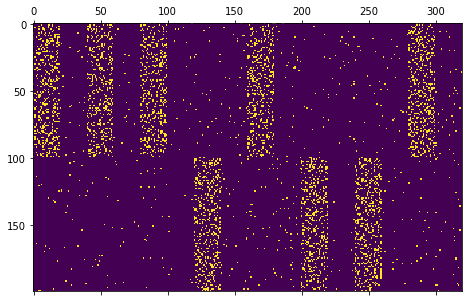

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -4.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -4.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
#         'rest':-57
    }
}
backward_args = {
    'potential_percent': torch.distributions.beta.Beta(3, 40),  # ("random", 0.1, 0.7),
    'connection_rate': 0.2,
    'before_computation_delay': 0,
    'update_rule': PostPreWMatrix,
    'direct_voltage_manipulation': True,
    'wmin': 0.,
    'wmax': 1.,
    'nu': [0.003, 0.005],
    'enable': True,
}
connection_type = RandomConnection

In [8]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=6)
input_name = f'input_{model_name}'
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, backward_args=backward_args, backward=True, name=model_name, monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection((input_name, input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 0.5,
    'nu': [0.02, 0.01],
#     'update_rule': PostPre,
    'probability': 0.30,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 6,
    'tc_minus': 6, 
    'tc_e_trace': 6,
})

In [9]:
for so,ta,c in c1.backward_connection.connections:
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c1_l23__exc1 c1_l4__exc1 tensor(0.0144) tensor(0.0735) 


c1_l23__exc1 c1_l4__exc2 tensor(0.0131) tensor(0.0691) 


c1_l23__exc2 c1_l4__exc1 tensor(0.0141) tensor(0.0698) 


c1_l23__exc2 c1_l4__exc2 tensor(0.0139) tensor(0.0713) 




In [10]:
c1_with_input = ComplexStructure()
c1_with_input.add_pop(input_name, input_pop_c1)
c1_with_input.add_submodule(c1)
c1_with_input.add_submodule(input_to_c1_connection)
c1_with_input.add_outpops(c1.get_output_pops())

In [11]:
network = Network(dt=1.0)
c1_with_input.add_to_network(network)

bl_monitors = []
bl_monitors_name = []
for a, b, con in input_to_c1_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [12]:
# Disable Learning of Backward Connections
# c1.backward_connection.disable_learning()

In [13]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c1.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c1.l23.enable_learning()
#         c1.l4_l23.enable_learning()

#     if part == backward_connection_involve_from:
#         c1_with_input.disable_learning()
#         c1.backward_connection.enable_learning()
#         c1.backward_connection.broadcast("set_enable")
        
    inp = {input_name: spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.1 + gap
    else:
        reward = -1 - gap
    
#     if pattern and exc1_act > 20 and exc2_act < 10:
#         reward = 1.0 + gap
#     elif not pattern and exc2_act > 20 and exc1_act < 10:
#         reward = 1.0 + gap
#     elif exc1_wins != pattern:
#         reward = -1 - gap
#     else:
#         reward = -0.1
        
    rewards.append(reward)
    
    for conn in input_to_c1_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|█| 1000/1000 [02:30


In [14]:
# c1.l23.disable_learning()
# c1.l4_l23.disable_learning

In [15]:
rewards[-300:]

[tensor(5.0312),
 tensor(5.),
 tensor(4.9375),
 tensor(5.7188),
 tensor(5.0312),
 tensor(6.),
 tensor(4.9375),
 tensor(4.4688),
 tensor(4.8438),
 tensor(4.7188),
 tensor(4.9688),
 tensor(5.1250),
 tensor(4.5000),
 tensor(4.9375),
 tensor(5.),
 tensor(5.0312),
 tensor(4.6875),
 tensor(5.0625),
 tensor(4.6250),
 tensor(5.6250),
 tensor(5.0312),
 tensor(4.3438),
 tensor(5.1562),
 tensor(5.3750),
 tensor(5.2500),
 tensor(5.9688),
 tensor(4.8750),
 tensor(5.1250),
 tensor(4.0625),
 tensor(4.9688),
 tensor(5.),
 tensor(4.9688),
 tensor(5.1562),
 tensor(5.3438),
 tensor(4.9688),
 tensor(5.1250),
 tensor(4.1875),
 tensor(4.9062),
 tensor(4.9688),
 tensor(5.0625),
 tensor(4.1250),
 tensor(4.8125),
 tensor(5.1562),
 tensor(4.8125),
 tensor(5.1250),
 tensor(4.9375),
 tensor(4.9062),
 tensor(5.1562),
 tensor(4.5938),
 tensor(5.1875),
 tensor(5.),
 tensor(5.0312),
 tensor(5.4375),
 tensor(5.2500),
 tensor(5.),
 tensor(5.0312),
 tensor(4.0625),
 tensor(5.1875),
 tensor(5.9688),
 tensor(4.8750),
 ten

In [16]:
session_class[-300:]

tensor([ True, False,  True,  True, False, False,  True, False,  True, False,
         True,  True,  True, False,  True, False,  True,  True, False, False,
         True, False, False, False,  True,  True, False, False,  True, False,
         True, False, False, False,  True,  True, False,  True, False, False,
         True, False,  True, False, False,  True, False, False,  True,  True,
         True, False, False, False,  True, False, False, False, False,  True,
        False,  True, False,  True, False, False,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True, False, False, False, False,  True, False,
        False,  True, False,  True, False, False,  True, False, False, False,
         True, False, False,  True, False,  True, False,  True,  True,  True,
        False, False,  True, False, False,  True, False, False,  True,  True,
        False, False,  True, False,  True, False,  True,  True, 

In [17]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('input_c1', 'c1_l4__exc1')
('input_c1', 'c1_l4__exc2')


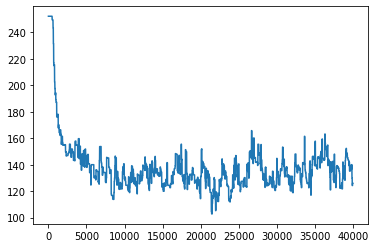

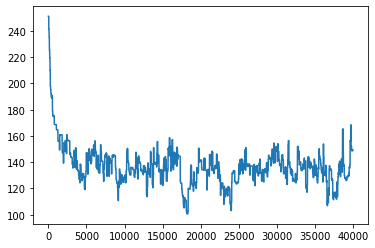

In [18]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [19]:
# plt.plot(inp_2_c1_monitor_1.get('converge'))
# plt.figure()
# plt.plot(inp_2_c1_monitor_2.get('converge'))

In [20]:
time_show = time

In [21]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    342.25
L4 -- Excitatory 1 -- Pattern 2     :    21.461538314819336
L4 -- Excitatory 2 -- Pattern 1     :    4.125
L4 -- Excitatory 2 -- Pattern 2     :    218.84616088867188


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    287.25
L4 -- Excitatory 1 -- Pattern 2     :    14.354166984558105
L4 -- Excitatory 2 -- Pattern 1     :    10.5
L4 -- Excitatory 2 -- Pattern 2     :    274.125


In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    347.2830810546875
L4 -- Excitatory 1 -- Pattern 2     :    2.6836934089660645
L4 -- Excitatory 2 -- Pattern 1     :    5.340122222900391
L4 -- Excitatory 2 -- Pattern 2     :    353.7229919433594


### Layer 2,3

In [25]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    116.20833587646484
L4 -- Excitatory 1 -- Pattern 2     :    8.692307472229004
L4 -- Excitatory 2 -- Pattern 1     :    0.3333333432674408
L4 -- Excitatory 2 -- Pattern 2     :    70.19230651855469


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    97.42308044433594
L23 -- Excitatory 1 -- Pattern 2     :    4.708333492279053
L23 -- Excitatory 2 -- Pattern 1     :    4.384615421295166
L23 -- Excitatory 2 -- Pattern 2     :    90.66666412353516


In [27]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    119.28717041015625
L23 -- Excitatory 1 -- Pattern 2     :    1.072691559791565
L23 -- Excitatory 2 -- Pattern 1     :    2.3706719875335693
L23 -- Excitatory 2 -- Pattern 2     :    122.08644104003906


## Pattern Separation

In [28]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c1 (0:99)    --->   c1_l4__exc1   :   1401.85400390625
input_c1 (100:199) --->   c1_l4__exc1   :   419.25421142578125
input_c1 (0:99)    --->   c1_l4__exc2   :   609.038330078125
input_c1 (100:199) --->   c1_l4__exc2   :   2321.576171875


In [29]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

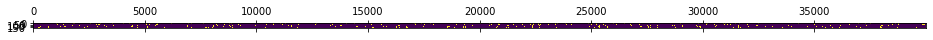

In [30]:
plt.matshow(spike_train.T[:, -time_show:])

In [31]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([40000, 1, 100])

In [32]:
spikes["L4 | 1"].shape

torch.Size([100, 40000])

In [33]:
spikes["L4 | 1"].sum(0).shape[0]

40000

In [34]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False]])

In [35]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(0)

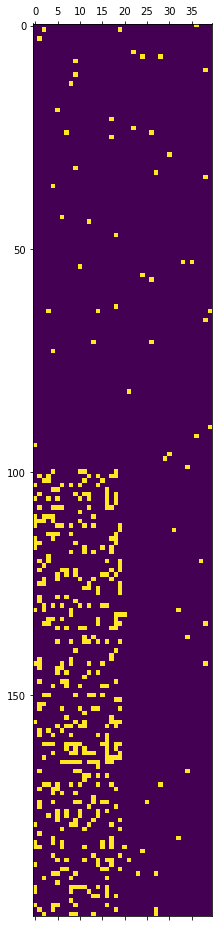

In [36]:
x = 999
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

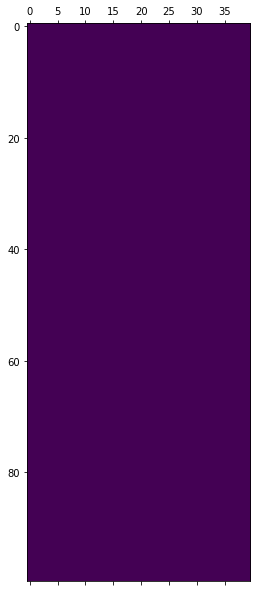

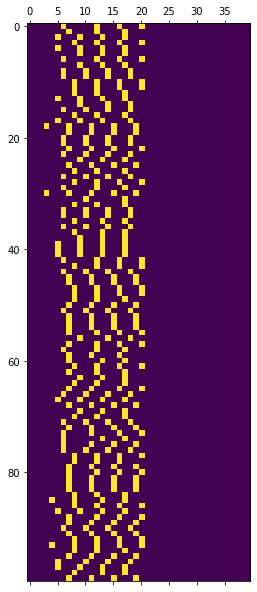

In [37]:
x = 999
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

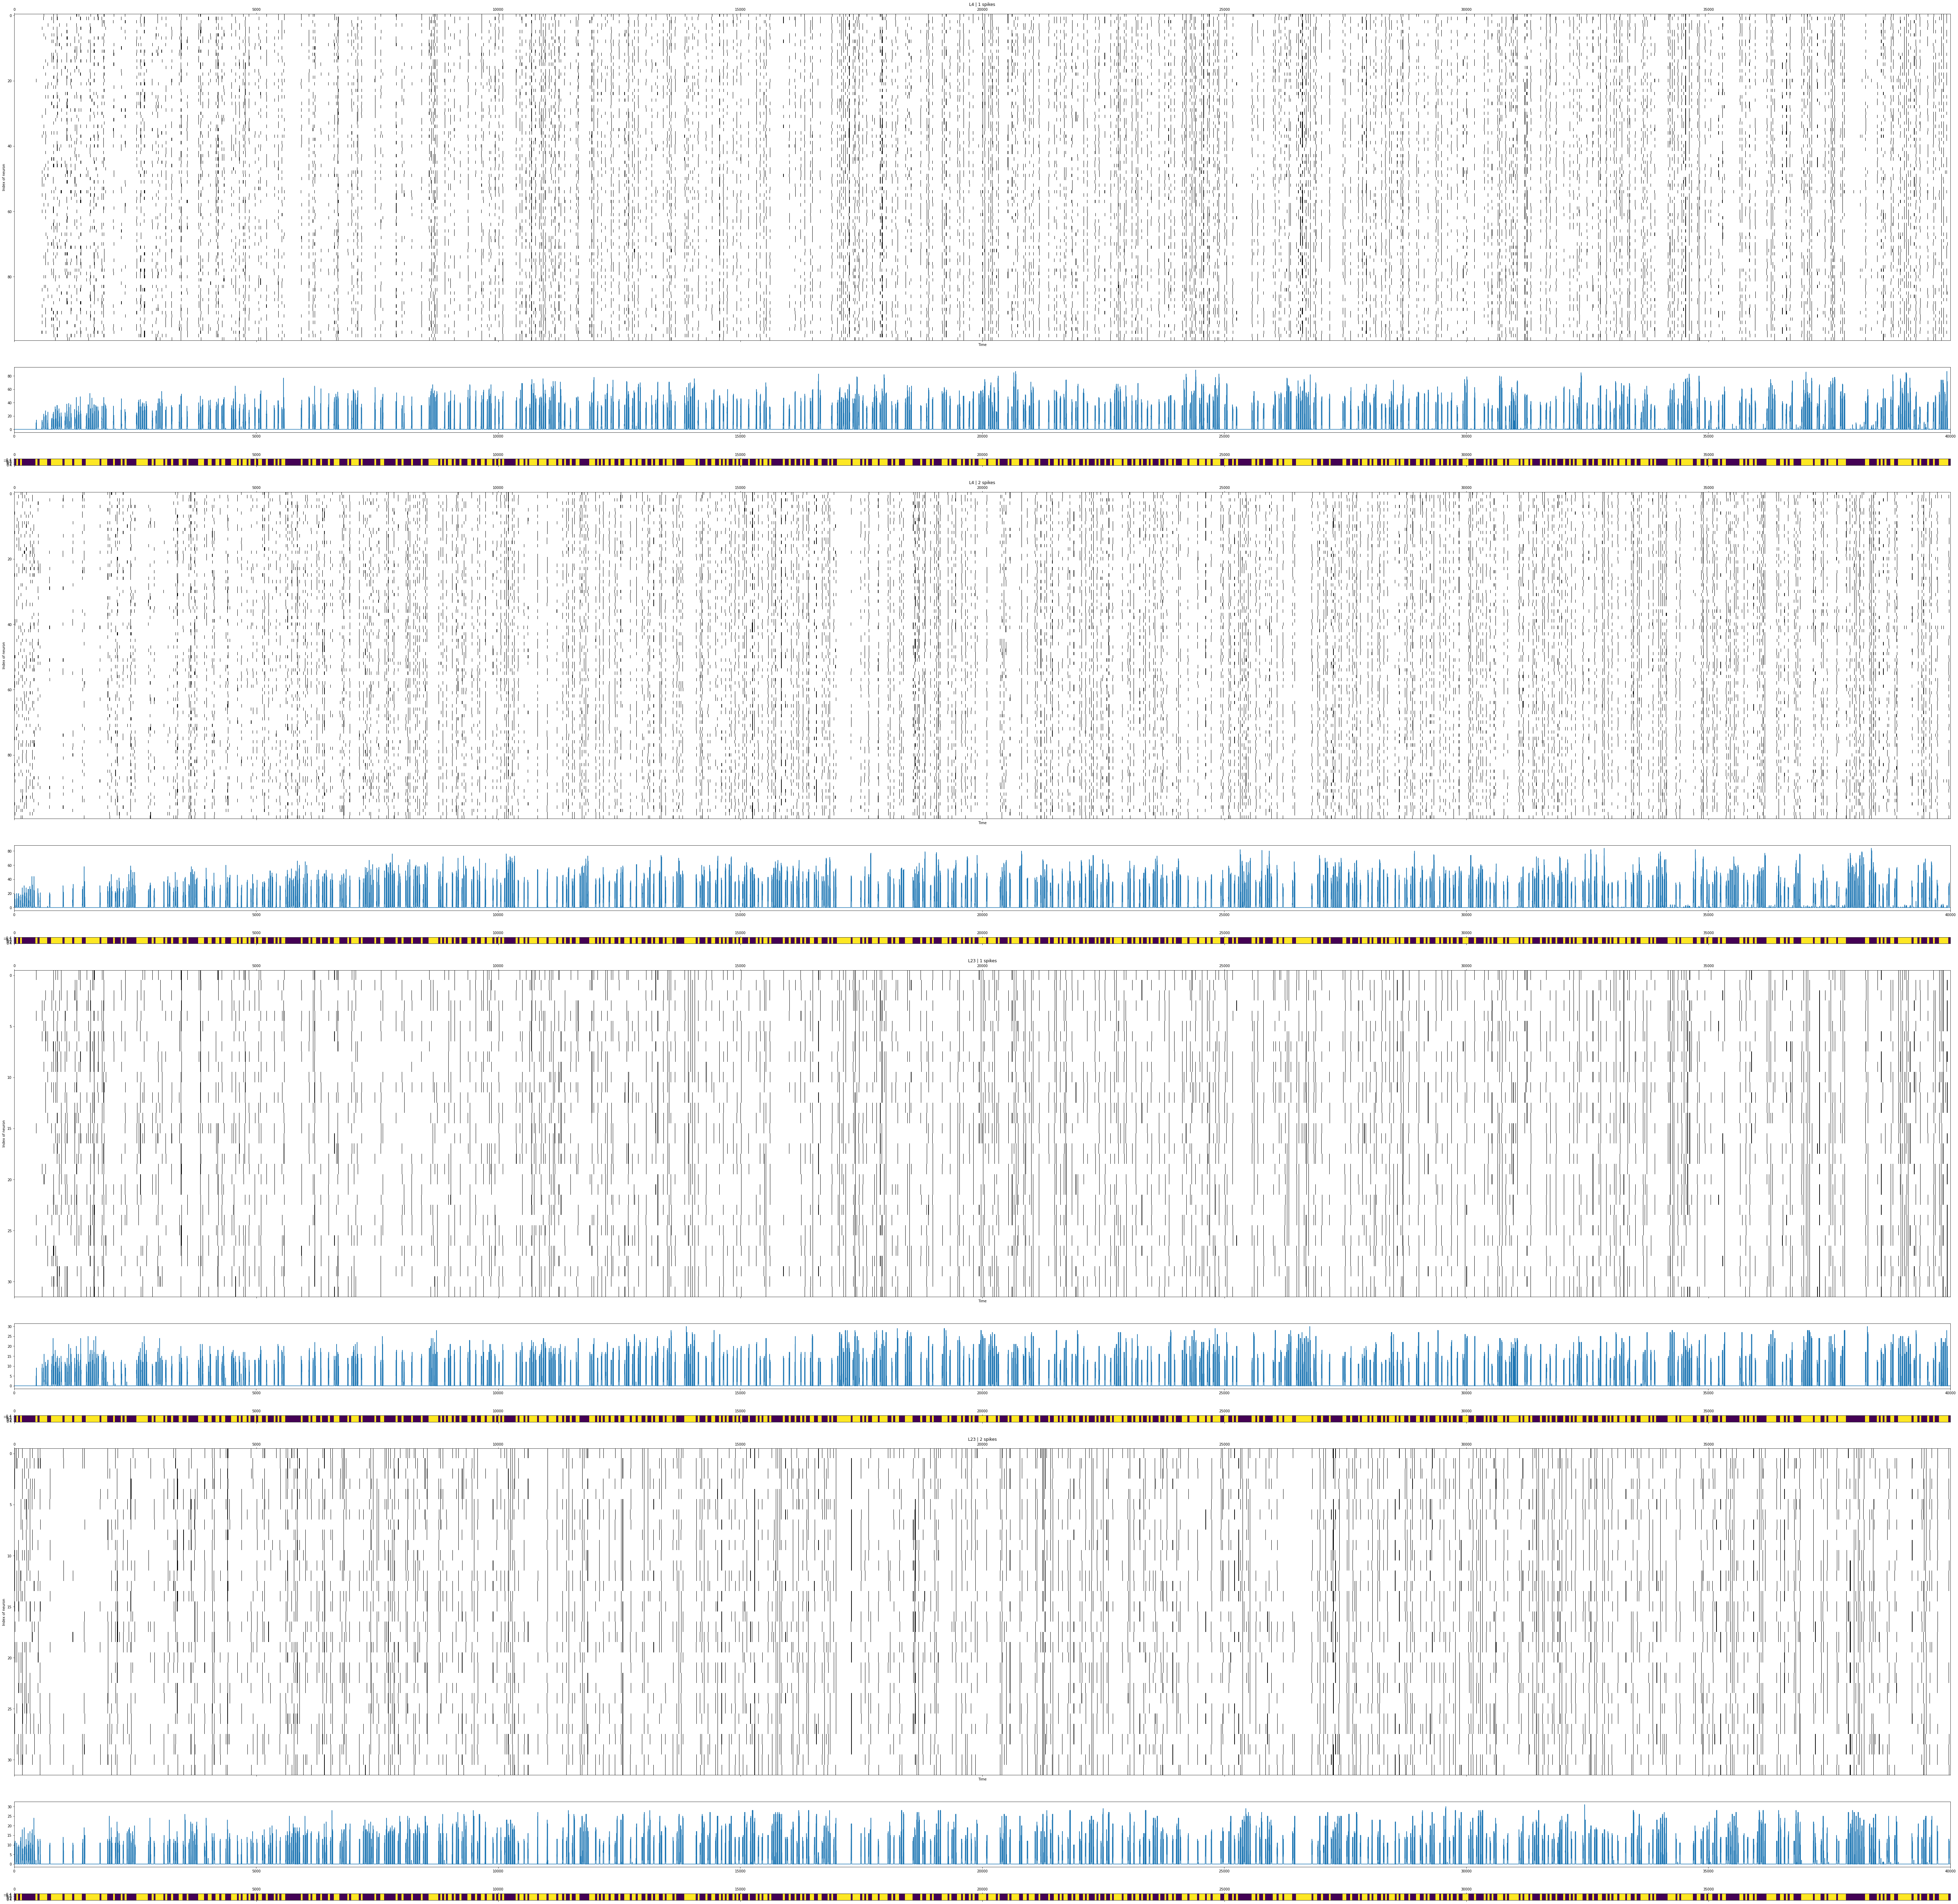

In [38]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

tensor(False)
tensor(True)
tensor(False)
tensor(True)
tensor(False)
tensor(False)
tensor(True)
tensor(False)
tensor(False)
tensor(False)


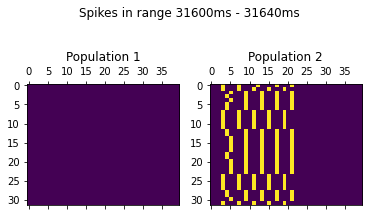

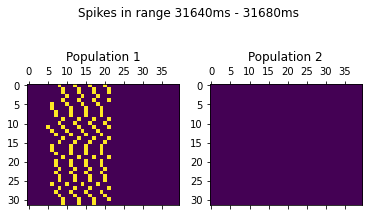

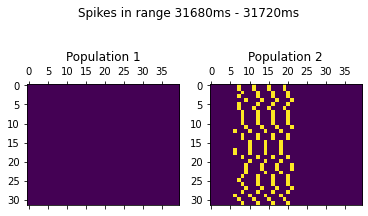

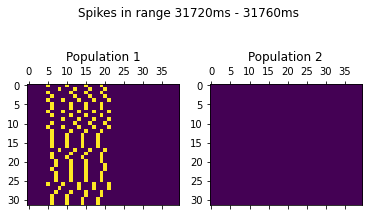

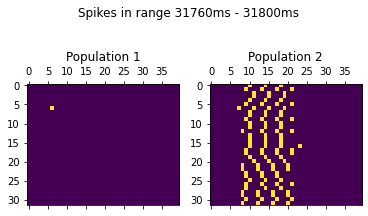

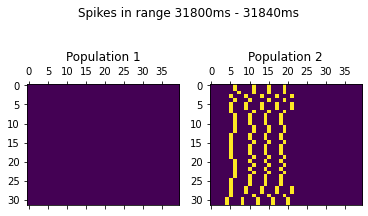

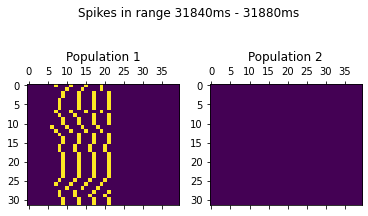

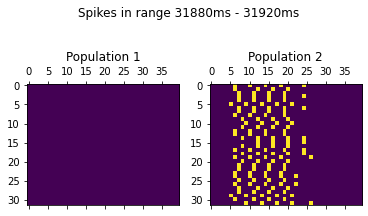

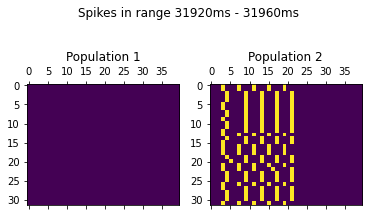

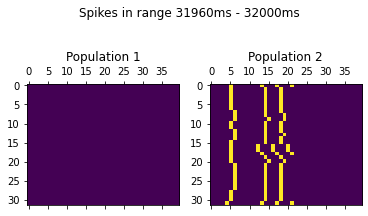

In [39]:
# x = 499
for x in range(backward_connection_involve_from - 10, backward_connection_involve_from):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(session_class[x])
#     plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
    ax1.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
    ax2.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')
    ax1.set_title("Population 1")
    ax2.set_title("Population 2")

tensor(True)
tensor(False)
tensor(False)
tensor(True)
tensor(False)
tensor(True)
tensor(False)
tensor(True)
tensor(True)
tensor(True)


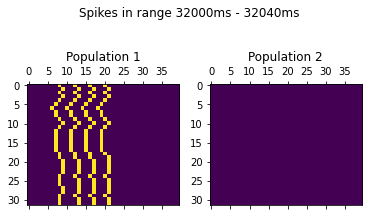

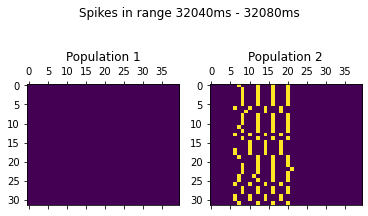

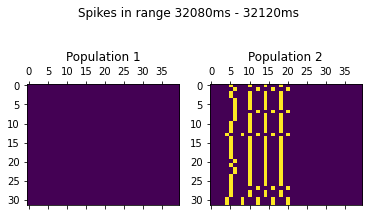

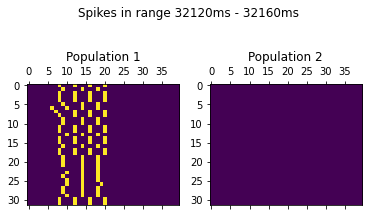

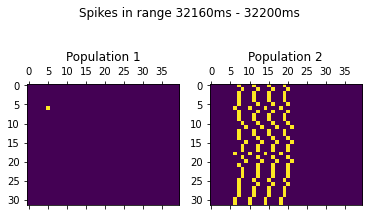

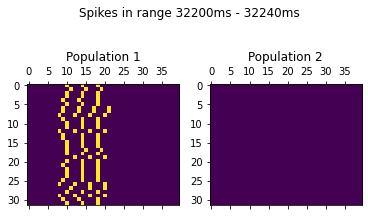

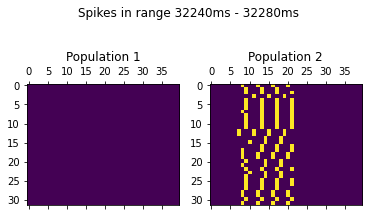

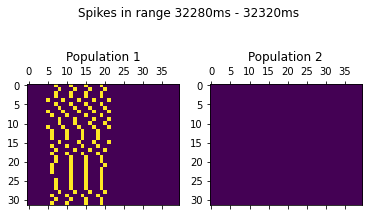

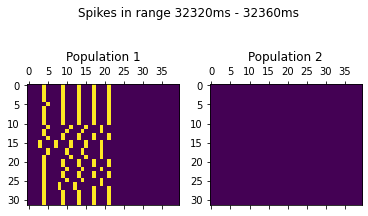

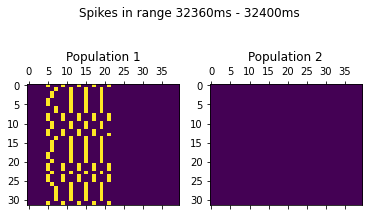

In [40]:
for x in range(backward_connection_involve_from, backward_connection_involve_from + 10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(session_class[x])
#     plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
    ax1.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
    ax2.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')
    ax1.set_title("Population 1")
    ax2.set_title("Population 2")

tensor(False)
tensor(True)
tensor(False)
tensor(False)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(False)


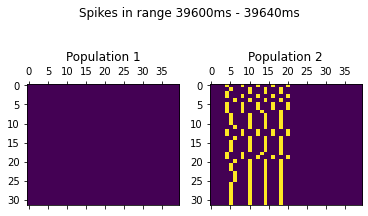

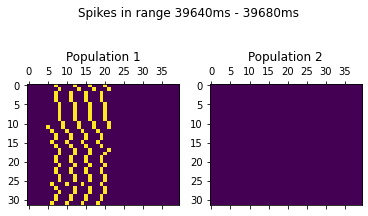

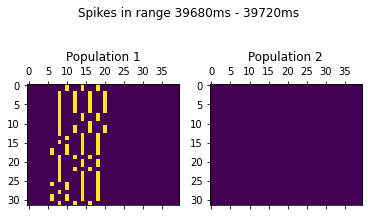

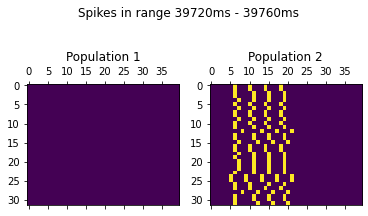

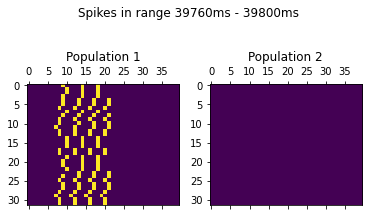

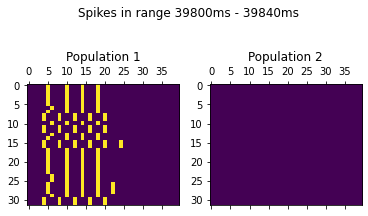

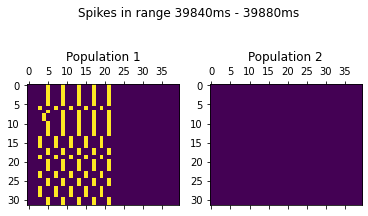

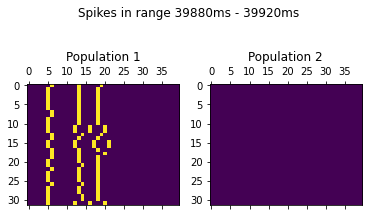

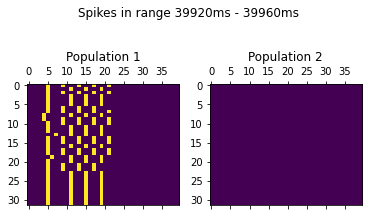

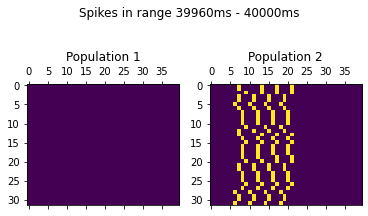

In [41]:
# x = 499
for x in range(session_number - 10, session_number):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(session_class[x])
#     plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
    ax1.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
    ax2.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')
    ax1.set_title("Population 1")
    ax2.set_title("Population 2")

# Add Backward Connections

In [42]:
# c1.backward_connection.broadcast("set_enable")

In [43]:
c1.backward_connection.connections[0][2].enable

True

In [44]:
for so,ta,c in c1.backward_connection.connections:
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c1_l23__exc1 c1_l4__exc1 tensor(0.2084) tensor(0.9981) 


c1_l23__exc1 c1_l4__exc2 tensor(0.0485) tensor(0.2580) 


c1_l23__exc2 c1_l4__exc1 tensor(0.0499) tensor(0.2525) 


c1_l23__exc2 c1_l4__exc2 tensor(0.1991) tensor(0.9985) 




In [45]:
(c1.backward_connection.connections[2][2].w == 0).sum()

tensor(2567)

# Save Model And Notebook

In [46]:
%%javascript
function custom_kernel_ready_handler() {
    require(["base/js/namespace"],function(Jupyter) {
        Jupyter.notebook.save_checkpoint();
    });
    IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
}

function handle_kernel_ready() {
    // Create a nb_name variable with the name of the notebook
     console.log('kernel_ready.Kernel: handle_kernel_ready() was triggered!');
     custom_kernel_ready_handler();

     Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
         //this recursive behavior is esential for `restart` kernel
         handle_kernel_ready();
    });
}

Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
     handle_kernel_ready();
});

handle_kernel_ready();

<IPython.core.display.Javascript object>

In [47]:
c1_with_input.disable_learning()
c1_with_input.save(f'models/{model_name}.pt')

In [48]:
import os
command = os.popen(f"jupyter-nbconvert --to html ./{nb_name} --stdout > models/{model_name}.html")